In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable
from matplotlib import cm
import scipy.io


step: 0  loss = 0.5307537317276001
step: 100  loss = 0.45461809635162354
step: 200  loss = 0.442350834608078
step: 300  loss = 0.4360138177871704
step: 400  loss = 0.4273911714553833
step: 500  loss = 0.4159131646156311
step: 600  loss = 0.40410786867141724
step: 700  loss = 0.38574662804603577
step: 800  loss = 0.33469894528388977
step: 900  loss = 0.21498452126979828


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14420\3161340950.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[i][j] = net(ctemp).detach().cpu().numpy()


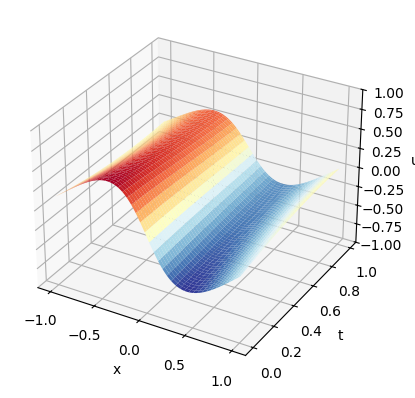

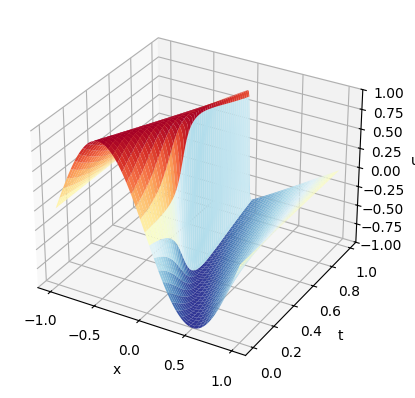

In [26]:
class Net(nn.Module):
    def __init__(self, NL, NN):
        # NL是有多少层隐藏层
        # NN是每层的神经元数量
        super(Net, self).__init__()
        self.input_layer = nn.Linear(2, NN)
        self.hidden_layer = nn.ModuleList([nn.Linear(NN, NN) for i in range(NL)])
        self.output_layer = nn.Linear(NN, 1)
 
    def forward(self, x):
        o = self.act(self.input_layer(x))
        for i, li in enumerate(self.hidden_layer):
            o = self.act(li(o))
        out = self.output_layer(o)
        return out
 
    def act(self, x):
        return torch.tanh(x)
 
 
"""
用来生成拟合函数、初值条件、边界条件的输入
这里是用torch.rand随机生成，并且根据取值范围调整了表达式
"""
 
 
def sample(size):
    x = torch.cat((torch.rand([size, 1]), torch.full([size, 1], -1) + torch.rand([size, 1]) * 2), dim=1)
    # 因为后面有sin(πx),所以这里得先把x存下来，并且保证和带入初值的x_initial(t,x)的x部分是相同的
    x_init = torch.full([size, 1], -1) + torch.rand([size, 1]) * 2
    x_initial = torch.cat((torch.zeros(size, 1), x_init), dim=1)
    x_boundary_left = torch.cat((torch.rand([size, 1]), torch.full([size, 1], -1)), dim=1)
    x_boundary_right = torch.cat((torch.rand([size, 1]), torch.ones([size, 1])), dim=1)
    return x, x_initial, x_init, x_boundary_left, x_boundary_right
 
 
if __name__ == '__main__':
    size = 2000
    lr = 1e-4
    x_train, x_initial, x_init, x_left, x_right = sample(size)
    net = Net(NL=4, NN=20)
    optimizer = optim.Adam(net.parameters(), lr)
    loss_fn = nn.MSELoss(reduction='mean')
    for i in range(1000):
        x = Variable(x_train, requires_grad=True)
        d = torch.autograd.grad(net(x), x, grad_outputs=torch.ones_like(net(x)), create_graph=True)
        dt = d[0][:, 0].unsqueeze(-1)
        dx = d[0][:, 1].unsqueeze(-1)
        dxx = torch.autograd.grad(dx, x, grad_outputs=torch.ones_like(dx), create_graph=True)[0][:, 1].unsqueeze(-1)
        # 先把该求的求完然后清零，减少影响（虽然不知道有没有用）
        optimizer.zero_grad()
        y_train = net(x)
        # 为了少生成几个零矩阵，所以计算损失的时候把条件移到两边了
        loss1 = loss_fn(dt + y_train * dx, (0.01 / np.pi) * dxx)
        loss2 = loss_fn(net(x_initial), -1 * torch.sin(np.pi * x_init))
        loss3 = loss_fn(net(x_left), torch.zeros([size, 1]))
        loss4 = loss_fn(net(x_right), torch.zeros([size, 1]))
        loss = loss1 + loss2 + loss3 + loss4
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'step: {i}  loss = {loss.item()}')
    """
    接下来引入正确解 画图进行比较
    """
    data = scipy.io.loadmat('burgers_shock.mat')
    t = data['t'].flatten()[:, None]
    x = data['x'].flatten()[:, None]
    Exact = np.real(data['usol']).T
 
    temp = np.empty((2, 1))
    i = 0
    j = 0
    pred = np.zeros((100, 256))
    for _t in t:
        temp[0] = _t
        for _x in x:
            temp[1] = _x
            ctemp = torch.Tensor(temp.reshape(1, -1))
            pred[i][j] = net(ctemp).detach().cpu().numpy()
            j = j + 1
            if j == 256:
                j = 0
        i = i + 1
    T, X = np.meshgrid(t, x, indexing='ij')
    pred_surface = np.reshape(pred, (t.shape[0], x.shape[0]))
    Exact_surface = np.reshape(Exact, (t.shape[0], x.shape[0]))
 
    # plot the approximated values
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_zlim([-1, 1])
    ax.plot_surface(X, T, pred_surface, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    plt.savefig('Preddata.png')
    plt.show(fig)
    # plot the exact solution
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_zlim([-1, 1])
    ax.plot_surface(X, T, Exact_surface, cmap=cm.RdYlBu_r, edgecolor='blue', linewidth=0.0003, antialiased=True)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    plt.savefig('Turedata.png')
    plt.show(fig)